In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, roc_curve, roc_auc_score

In [24]:
DATA_PATH = 'Data/'
MODEL_PREDICTIONS_PATH = 'ModelPredictions/'

EVAL_DATASET = 'test.csv'
EVAL_NAME = 'test'
MAX_K = 20

In [6]:
def load_csv(path, header=0, sep=','):
    df = pd.read_csv(
        path,
        sep=sep,
        keep_default_na=False,
        na_values=[""],
        index_col=False,
        header=header,
    )
    print('--- Loaded %d records from %s' % (len(df), path))
    return df

In [9]:
class MovieVocab(object):
    def __init__(self, data_path, do_lowercase):
        self.do_lowercase = do_lowercase
        df = load_csv(data_path)
        df['asin_normalized'] = df.asin.apply(self._normalize_movie)
        df = df.drop(columns=['asin'])
        df = df.rename(columns={'asin_normalized': 'asin'})        
        self.idx2movie = df.asin.unique()        
        self.movie2idx = dict()
        for idx, movie in enumerate(self.idx2movie):
            self.movie2idx[movie] = idx
        assert len(self.idx2movie) == len(self.movie2idx)
        print('--- Found %d unique movie IDs' % len(self))
    
    def _normalize_movie(self, x):
        if self.do_lowercase:
            return x.lower()
        else:
            return x
    
    def __getitem__(self, movie):
        return self.movie2idx[movie]

    def get_movie_idx_df(self, df, input_column, output_column):
        df_removed = df[~df[input_column].apply(self._normalize_movie).isin(self.idx2movie)]
        if len(df_removed) > 0:
            print('--- WARNING: Filtered out %d items (%d unique movie IDs) with unknown movie ID' % (
                len(df_removed),
                len(df_removed[input_column].unique()),
            ))   
        df = df[df[input_column].apply(self._normalize_movie).isin(self.idx2movie)].copy()            
        df[output_column] = df[input_column].apply(lambda x: self.movie2idx[self._normalize_movie(x)])
        return df              
        
    def __len__(self):
        return len(self.idx2movie)

movie_vocab = MovieVocab(os.path.join(DATA_PATH, EVAL_DATASET), True)

# --- Loaded 141618 records from Data/test.csv
# --- Found 6392 unique movie IDs

--- Loaded 141618 records from Data/test.csv
--- Found 6392 unique movie IDs


In [11]:
class TagVocab(object):
    def __init__(self, data_path):
        self.tag2idx = load_csv(data_path).set_index('tag')
        print('--- Found %d unique tags' % len(self))
        
    def __getitem__(self, tag_str):
        return self.tag2idx.tag_idx[tag_str]
        
    def __len__(self):
        return len(self.tag2idx)

    def _all_tags(self):
        return self.tag2idx.index
    
    def get_tag_idx_df(self, df, input_column, output_column):    
        df[output_column] = df[input_column].apply(lambda x: self[x])
        return df

tag_vocab = TagVocab(os.path.join(DATA_PATH, 'tags.csv'))

# --- Loaded 1128 records from Data/tags.csv
# --- Found 1128 unique tags

--- Loaded 1128 records from Data/tags.csv
--- Found 1128 unique tags


In [13]:
class MovieLens(object):
    def __init__(self, data_path, movie_vocab, tag_vocab):
        df = load_csv(data_path)
        for i, row in df.iterrows():
            assert tag_vocab[row['tag']] == row['tag_idx']
        df = movie_vocab.get_movie_idx_df(df, "asin", "movie_idx")
        self.df = df[['user', 'tag_idx', 'movie_idx']]
        self.movies = np.sort(self.df.movie_idx.unique())
        self.tags = np.sort(self.df.tag_idx.unique())
        self.score = MovieLens.compute_user_score(df, movie_vocab, tag_vocab)
        print('--- MovieLens dataset: %d records, %d unique movies, %d unique tags, %d unique users' % (
            len(self.df), len(self.movies), len(self.tags), len(self.df.user.unique())))

    @staticmethod
    def compute_user_score(df, movie_vocab, tag_vocab):
        score = np.zeros((len(movie_vocab), len(tag_vocab)))
        user_scores = (
            df
            .groupby(['movie_idx', 'tag_idx'])
            .aggregate({'user': 'count'})
            .reset_index())        
        score[user_scores.movie_idx, user_scores.tag_idx] = user_scores.user
        return score
    
movielens = MovieLens(os.path.join(DATA_PATH, EVAL_DATASET), movie_vocab, tag_vocab)

# --- Loaded 141618 records from Data/test.csv
# --- MovieLens dataset: 141618 records, 6392 unique movies, 500 unique tags, 9479 unique users

--- Loaded 141618 records from Data/test.csv
--- MovieLens dataset: 141618 records, 6392 unique movies, 500 unique tags, 9479 unique users


In [15]:
class Model(object):
    def __init__(
        self,
        df,        
        score_column,
        movie_vocab,
        tag_vocab,
        tag_column=None,
        tag_idx_column=None,
        default_value=0,
    ):
        assert bool(tag_column) ^ bool(tag_idx_column)
        print('--- Applying Movie Vocab')
        df = movie_vocab.get_movie_idx_df(df, 'asin', "movie_idx")
        if tag_column is not None:
            print('--- Applying Tag Vocab')            
            df = tag_vocab.get_tag_idx_df(df, tag_column, 'tag_idx')
        self.movies = np.sort(df.movie_idx.unique())
        self.tags = np.sort(df.tag_idx.unique())
        print('--- Creating scores matrix')
        self.score = np.full(
            (len(movie_vocab), len(tag_vocab)), default_value, dtype=np.float32)
        print('--- Building scores matrix')        
        self.score[df.movie_idx, df.tag_idx] = df[score_column]
        print(
            '-- Created a model with %d predictions. '
            'Missing predictions for %d (movie, tag) pairs are using the value %.5f' % (
                len(df),
                len(movie_vocab) * len(tag_vocab) - len(df),
                default_value,
            )
        )

genome_model = Model(
    df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'tag_genome.csv')),
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
    score_column='relevance',
    tag_idx_column='tag_idx',
)

# --- Loaded 8875104 records from ModelPredictions/tag_genome.csv
# --- Applying Movie Vocab
# --- WARNING: Filtered out 1664928 items (1476 unique movie IDs) with unknown movie ID
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 7210176 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000

--- Loaded 8875104 records from ModelPredictions/tag_genome.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 1664928 items (1476 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 7210176 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000


In [26]:
def get_name(path):
    return os.path.split(path)[1][:-len('.csv')]

docent_models = {}

docent_models.update({
    get_name(path): Model(
        df=load_csv(path),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score_0',
        tag_idx_column='tag_idx',    
    )
    for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_full*.csv'))
})

docent_models.update({
    get_name(path): Model(
        df=load_csv(path),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='relevance',
        tag_idx_column='tag_idx',    
    )
    for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_dual*.csv'))
})

docent_models.update({
    get_name(path): Model(
        df=load_csv(path),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='relevance',
        tag_idx_column='tag_idx',    
    )
    for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_hybrid*.csv'))
})

test_tags = load_csv(os.path.join(DATA_PATH, EVAL_NAME + '.tag.csv')).tag

for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'bos_bert*.csv')):
    df = load_csv(path)
    df['tag'] = df.tag_idx.apply(lambda tag_idx: test_tags[tag_idx])
    docent_models[get_name(path)] = Model(
        df=df,
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score_0',
        tag_column='tag',    
    )
                      
docent_models.keys()                      

--- Loaded 3196160 records from ModelPredictions/docent_full_400.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 160 items (1 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 3196000 predictions. Missing predictions for 4014176 (movie, tag) pairs are using the value 0.00000
--- Loaded 3196160 records from ModelPredictions/docent_full_200.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 160 items (1 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 3196000 predictions. Missing predictions for 4014176 (movie, tag) pairs are using the value 0.00000
--- Loaded 3196160 records from ModelPredictions/docent_full_500.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 160 items (1 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 3196000 predictions. Missing predictions for 40

dict_keys(['docent_full_400', 'docent_full_200', 'docent_full_500', 'docent_full_100', 'docent_full_300', 'docent_dual_200', 'docent_dual_400', 'docent_dual_300', 'docent_dual_100', 'docent_dual_500', 'docent_hybrid_400', 'docent_hybrid_200', 'docent_hybrid_500', 'docent_hybrid_300', 'docent_hybrid_100', 'bos_bert_400', 'bos_bert_full', 'bos_bert_200', 'bos_bert_500', 'bos_bert_300', 'bos_bert_100'])

In [29]:
tf_idf_model = Model(
    df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'tf_idf.csv')), 
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
    score_column='score',
    tag_column='tag',   
    default_value=-1,
)      

--- Loaded 2695480 records from ModelPredictions/tf_idf.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 1468786 items (31384 unique movie IDs) with unknown movie ID
--- Applying Tag Vocab
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 1226694 predictions. Missing predictions for 5983482 (movie, tag) pairs are using the value -1.00000


In [30]:
def intersect_movie_and_tags(models, movies=None, tags=None):
    if movies is None:
        movies = np.arange(len(movie_vocab))
    else:
        movies = np.intersect1d(movies, movielens.movies)
  
    if tags is None:
        tags = np.arange(len(tag_vocab))
    else:
        tags = np.intersect1d(tags, movielens.tags)

    for name, model in models.items():
        movies = np.intersect1d(movies, model.movies)
        tags = np.intersect1d(tags, model.tags)
    
    print('--- Movies %d, Tags %d' % (len(movies), len(tags)))
    return movies, tags

def precision_at_k(binary_labels, num_labels_per_movie, sorted_predictions):
    num_movies = len(num_labels_per_movie)
    counter, precision = np.zeros((num_movies, MAX_K)), np.zeros((num_movies, MAX_K))
    prediction_labels = np.take_along_axis(binary_labels, sorted_predictions, axis=1)
  
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(len(num_labels_per_movie)):
            if k <= num_labels_per_movie[i]:
                precision[i, k_idx] = prediction_labels[i, :k].mean()
                counter[i, k_idx] = 1
    return precision.sum(axis=0) / (counter.sum(axis=0) + 1e-8)

def set_intersection_at_k(sorted_labels, num_labels_per_movie, sorted_predictions):
    num_movies = len(num_labels_per_movie)
    counter, set_intersection = np.zeros((num_movies, MAX_K)), np.zeros((num_movies, MAX_K))
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(num_movies):
            if k <= num_labels_per_movie[i]:
                set_intersection[i, k_idx] = (
                    len(np.intersect1d(sorted_labels[i, :k], sorted_predictions[i, :k]))
                    / float(k))
                counter[i, k_idx] = 1
    return set_intersection.sum(axis=0) / (counter.sum(axis=0) + 1e-8)
    
def dcg_at_k_per_movie(labels, predictions, use_log_for_user_counts):
    num_movies = labels.shape[0]
    dcg = np.zeros((num_movies, MAX_K))
    discounts = np.log2(np.arange(2, MAX_K + 2))
    for i in range(num_movies):
        gain = labels[i, predictions[i]]
        if use_log_for_user_counts:
            gain = np.log(gain + 1)        
        for k_idx in range(MAX_K):
            k = k_idx + 1
            dcg[i, k_idx] = np.sum(gain[:k] / discounts[:k])
    return dcg

def ndcg_at_k(labels, predictions, use_log_for_user_counts):
    actual_dcg = dcg_at_k_per_movie(labels, predictions, use_log_for_user_counts)
    ideal_predicitons = np.argsort(-labels, axis=1)
    ideal_dcg = dcg_at_k_per_movie(labels, ideal_predicitons, use_log_for_user_counts)
    ndcg = actual_dcg / (ideal_dcg + 1e-8)
    return ndcg.mean(axis=0)

def eval_model(
    models,
    labels=None,
    groundtruth_threshold=0,
):
    movies, tags = intersect_movie_and_tags(models, movies=None, tags=None)
    assert len(movies) > 0
    assert len(tags) > 0  

    if labels is None:
        labels = movielens.score[movies][:, tags]
    else:
        labels = labels[movies][:, tags]

    labels_flattened = (labels > groundtruth_threshold).reshape(-1)
    binary_labels = labels > groundtruth_threshold
    num_labels_per_movie = binary_labels.sum(axis=1)
    sorted_labels = np.argsort(-movielens.score[movies][:, tags], axis=1)
    movies_with_non_empty_labels = ((labels > groundtruth_threshold).sum(axis=1) > 0)
    num_movies_with_empty_labels = len(movies) - movies_with_non_empty_labels.sum()
    if num_movies_with_empty_labels > 0:
        print('--- WARNING: There are %d movies without any labels (tags): %s' % (
            num_movies_with_empty_labels,
            ','.join([str(i) for i, v in enumerate(movies_with_non_empty_labels) if v == 0])
        ))

    results = {}
    for name, model in models.items():  
        print('--- Model %s' % name)
        scores = model.score[movies][:, tags] 
        scores_flattened = scores.reshape(-1)      

        predictions = np.argsort(-scores, axis=1)
        result = {}
        result["precision@k"] = precision_at_k(
            binary_labels[movies_with_non_empty_labels],
            num_labels_per_movie[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
        )
        result["set_intersection@k"] = set_intersection_at_k(
            sorted_labels[movies_with_non_empty_labels],
            num_labels_per_movie[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
        )
        result["label_ranking_loss"] = label_ranking_loss(
            binary_labels[movies_with_non_empty_labels] > 0,
            scores[movies_with_non_empty_labels],
        )
        result["mean_average_precision"] = label_ranking_average_precision_score(
            binary_labels[movies_with_non_empty_labels] > 0,
            scores[movies_with_non_empty_labels],
        )
        result["ndcg_log@k"] = ndcg_at_k(
            labels[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
            True,
        )
        result["ndcg@k"] = ndcg_at_k(
            labels[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
            False,
        )
        fpr, tpr, _ = roc_curve(labels_flattened, scores_flattened)
        result["fpr"] = fpr
        result["tpr"] = tpr
        result["auc"] = roc_auc_score(labels_flattened, scores_flattened)

        results[name] = result

    return results, movies, tags

In [32]:
models = {
    'TagGenome': genome_model,
    'tf-idf': tf_idf_model,
}
models.update(docent_models)

results_movie_heldout, _, _ = eval_model(
    models=models,
    groundtruth_threshold=2,
)

--- Movies 6217, Tags 479
--- WARNING: There are 3400 movies without any labels (tags): 30,120,136,137,157,184,198,212,230,246,262,266,272,281,292,299,313,321,342,346,347,350,367,395,399,418,427,447,449,450,475,480,481,482,488,489,491,492,501,502,505,510,523,530,531,532,535,569,570,571,624,625,635,637,638,639,641,645,668,673,676,687,689,699,701,713,718,720,727,733,736,737,762,791,808,810,829,835,843,881,901,930,932,940,945,965,1005,1020,1074,1079,1083,1088,1091,1092,1094,1097,1099,1105,1110,1113,1123,1125,1131,1132,1145,1147,1151,1156,1157,1158,1159,1173,1183,1187,1198,1211,1213,1214,1222,1229,1230,1231,1245,1249,1250,1252,1256,1257,1258,1264,1271,1272,1276,1277,1278,1281,1284,1288,1293,1294,1296,1299,1300,1302,1306,1307,1308,1309,1313,1314,1318,1322,1324,1328,1332,1334,1335,1337,1338,1346,1347,1350,1352,1353,1354,1358,1359,1360,1361,1363,1365,1366,1367,1368,1369,1370,1372,1376,1383,1388,1400,1411,1413,1416,1429,1430,1453,1455,1458,1459,1461,1463,1465,1467,1468,1472,1474,1486,1487,1495

--- Model tf-idf
--- Model docent_full_400
--- Model docent_full_200
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300
--- Model docent_dual_200
--- Model docent_dual_400
--- Model docent_dual_300
--- Model docent_dual_100
--- Model docent_dual_500
--- Model docent_hybrid_400
--- Model docent_hybrid_200
--- Model docent_hybrid_500
--- Model docent_hybrid_300
--- Model docent_hybrid_100
--- Model bos_bert_400
--- Model bos_bert_full
--- Model bos_bert_200
--- Model bos_bert_500
--- Model bos_bert_300
--- Model bos_bert_100


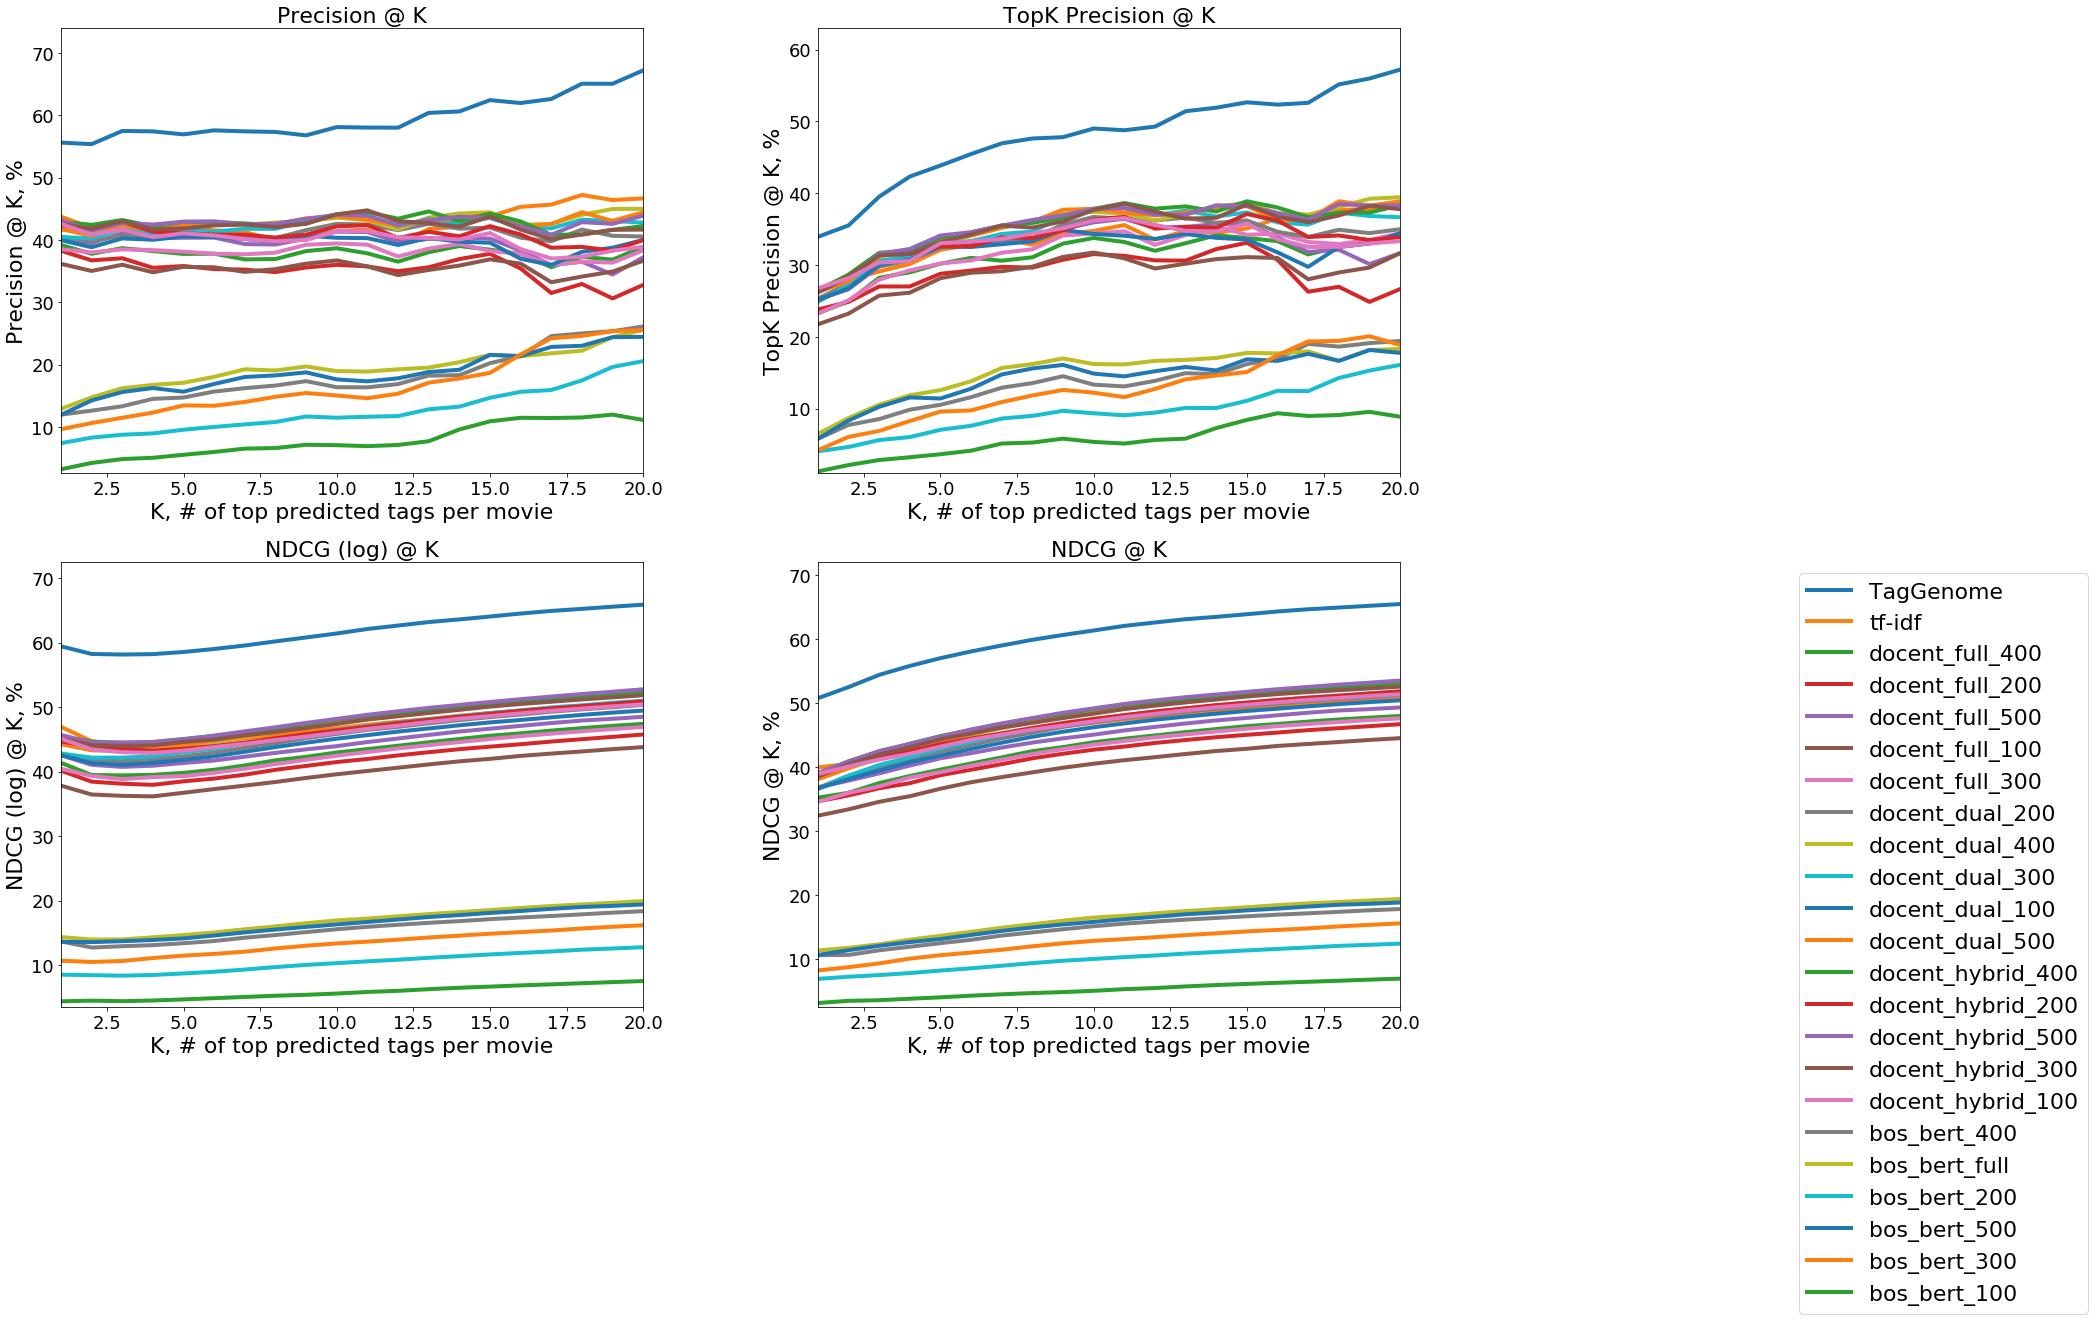

In [33]:
METRIC_LABELS = {
    'precision@k': 'Precision @ K',
    'set_intersection@k': 'TopK Precision @ K',
    'ndcg_log@k': 'NDCG (log) @ K',
    'ndcg@k': 'NDCG @ K',
}

def plot_ranking_results(results):  
    ALL_METRICS = METRIC_LABELS.keys()
    krange = np.arange(1, MAX_K + 1)
    plt.figure(figsize=(24, 18))#, dpi=400)

    for i, metric in enumerate(ALL_METRICS):
        ax = plt.subplot(2, 2, i + 1)
        y_min = min([result[metric].min() for _, result in results.items()])
        y_max = max([result[metric].max() for _, result in results.items()])
        plt.ylim(y_min * 80, y_max * 110)
        plt.xlim(1, MAX_K)
        for name, result in results.items():
            ax.plot(krange, result[metric] * 100.0, label=name, linewidth=4)
            
        plt.title(METRIC_LABELS[metric], fontsize=22)
        plt.ylabel(METRIC_LABELS[metric] + ', %', fontsize=22)
        plt.xlabel('K, # of top predicted tags per movie', fontsize=22)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(18)
  
    plt.legend(loc='upper right', bbox_to_anchor=(2.2, 1), fontsize=22)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

plot_ranking_results(results_movie_heldout)

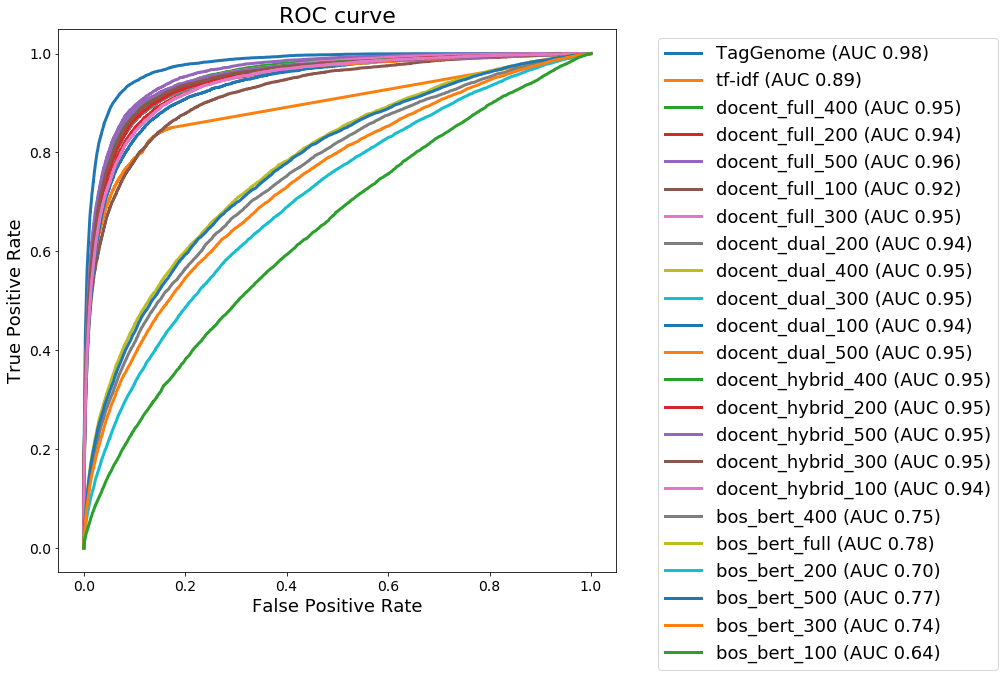

In [34]:
def plot_binary_results(results):    
    plt.figure(figsize=(10, 10))#, dpi=400)
    ax = plt.subplot(1, 1, 1)
    for name, result in results.items():
        if "fpr" in result and "tpr" in result:
            ax.plot(result["fpr"], result["tpr"], label='%s (AUC %.2f)' % (name, result["auc"]), linewidth=3)
        
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=18)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC curve', fontsize=22)
    plt.show()

plot_binary_results(results_movie_heldout)

In [35]:
class HumanScoresModel(object):
    def __init__(self, df, movie_vocab, tag_vocab):
        self.movies = np.arange(len(movie_vocab))
        self.tags = np.arange(len(tag_vocab))
        self.score = MovieLens.compute_user_score(df, movie_vocab, tag_vocab)
#         self.score /= (self.score.sum(axis=1, keepdims=True) + 1e-8)

def human_cv_eval(movielens, movie_vocab, tag_vocab, cv_num_folds, models=None, groundtruth_threshold=0):
    users = movielens.df.user.unique()
    assert cv_num_folds <= len(users)
    num_users_per_fold = int((len(users) + cv_num_folds - 1) / cv_num_folds)
    np.random.seed(31415)
    users_perm = np.random.permutation(len(users))

    all_folds_results = []
    for cv_step, i in enumerate(range(0, len(users), num_users_per_fold)):
        users_heldout = users[users_perm[i:min(i+num_users_per_fold, len(users))]]
    
        model = HumanScoresModel(
            df=movielens.df[~movielens.df.user.isin(users_heldout)].copy(),
            movie_vocab=movie_vocab,
            tag_vocab=tag_vocab,
        )
        labels = MovieLens.compute_user_score(
            movielens.df[movielens.df.user.isin(users_heldout)].copy(),
            movie_vocab=movie_vocab,
            tag_vocab=tag_vocab,
        )
        
        current_models = {
            'Human': model,
        }
        if models is not None:
            current_models.update(models)
        
        all_folds_results.append(eval_model(
            models=current_models,
            labels=labels,
            groundtruth_threshold=groundtruth_threshold)[0])
  
    models_names = ['Human']
    if models is not None:
        models_names.extend(models.keys())
    averaged_results = {}
    for model_name in models_names:
        allmetrics = set([
            metric            
            for current_fold_result in all_folds_results            
            for metric in current_fold_result[model_name].keys()

        ])    
        averaged_results[model_name] = dict()
        for metric in allmetrics:
            if metric in ["tpr", "fpr"]:
                continue
            averaged_results[model_name][metric] = np.stack([
                current_fold_result[model_name][metric]
                for current_fold_result in all_folds_results                
            ]).mean(axis=0)
    return averaged_results 

models = {
    'TagGenome': genome_model,
    'tf-idf': tf_idf_model,
}
models.update(docent_models)

results_movie_heldout_with_human = human_cv_eval(
    movielens=movielens,
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
    cv_num_folds=3,
    models=models,
    groundtruth_threshold=2,
)

--- Movies 6217, Tags 479
--- WARNING: There are 4623 movies without any labels (tags): 6,30,41,45,46,48,57,70,74,79,120,129,130,136,137,151,153,157,159,162,167,171,182,184,188,189,192,196,198,203,205,207,212,216,218,223,230,233,240,241,242,244,246,248,258,262,263,266,272,281,292,299,300,302,313,316,318,320,321,323,336,338,340,342,344,346,347,348,350,353,364,366,367,368,378,382,384,387,393,395,396,397,399,403,406,407,408,409,418,426,427,428,439,440,441,446,447,448,449,450,458,460,461,475,480,481,482,483,484,485,487,488,489,491,492,493,495,499,501,502,505,509,510,512,516,521,523,530,531,532,535,540,547,549,550,569,570,571,581,589,590,596,598,604,612,613,614,617,622,624,625,628,629,632,633,635,637,638,639,640,641,643,644,645,647,649,650,668,670,673,674,676,679,680,682,683,685,686,687,689,690,693,698,699,701,713,714,718,720,727,729,733,735,736,737,742,743,746,752,755,761,762,763,787,791,796,799,803,806,807,808,810,811,812,813,819,829,832,834,835,838,839,840,843,845,849,851,857,867,868,875

--- Model TagGenome
--- Model tf-idf
--- Model docent_full_400
--- Model docent_full_200
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300
--- Model docent_dual_200
--- Model docent_dual_400
--- Model docent_dual_300
--- Model docent_dual_100
--- Model docent_dual_500
--- Model docent_hybrid_400
--- Model docent_hybrid_200
--- Model docent_hybrid_500
--- Model docent_hybrid_300
--- Model docent_hybrid_100
--- Model bos_bert_400
--- Model bos_bert_full
--- Model bos_bert_200
--- Model bos_bert_500
--- Model bos_bert_300
--- Model bos_bert_100
--- Movies 6217, Tags 479
--- WARNING: There are 4819 movies without any labels (tags): 6,27,30,33,45,46,48,56,57,60,61,74,75,90,96,110,120,129,130,136,137,153,157,159,167,171,178,182,184,188,192,193,196,198,205,206,207,210,212,213,216,219,223,230,233,239,244,246,258,262,263,266,272,281,282,292,298,299,302,313,315,316,318,321,322,332,336,338,340,341,342,344,346,347,348,350,353,366,367,368,378,395,396,397,399,409,417,418,

--- Model TagGenome
--- Model tf-idf
--- Model docent_full_400
--- Model docent_full_200
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300
--- Model docent_dual_200
--- Model docent_dual_400
--- Model docent_dual_300
--- Model docent_dual_100
--- Model docent_dual_500
--- Model docent_hybrid_400
--- Model docent_hybrid_200
--- Model docent_hybrid_500
--- Model docent_hybrid_300
--- Model docent_hybrid_100
--- Model bos_bert_400
--- Model bos_bert_full
--- Model bos_bert_200
--- Model bos_bert_500
--- Model bos_bert_300
--- Model bos_bert_100
--- Movies 6217, Tags 479
--- WARNING: There are 4751 movies without any labels (tags): 6,30,45,46,57,58,61,67,70,75,79,96,107,108,120,124,130,136,137,138,157,159,162,182,184,185,188,191,194,198,203,205,206,210,212,213,216,219,223,230,233,239,241,242,244,246,249,254,257,262,263,266,269,272,281,282,285,292,298,299,300,313,315,316,319,320,321,332,335,336,337,338,340,342,344,346,347,348,350,351,353,367,368,382,390,395,396,3

--- Model TagGenome
--- Model tf-idf
--- Model docent_full_400
--- Model docent_full_200
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300
--- Model docent_dual_200
--- Model docent_dual_400
--- Model docent_dual_300
--- Model docent_dual_100
--- Model docent_dual_500
--- Model docent_hybrid_400
--- Model docent_hybrid_200
--- Model docent_hybrid_500
--- Model docent_hybrid_300
--- Model docent_hybrid_100
--- Model bos_bert_400
--- Model bos_bert_full
--- Model bos_bert_200
--- Model bos_bert_500
--- Model bos_bert_300
--- Model bos_bert_100


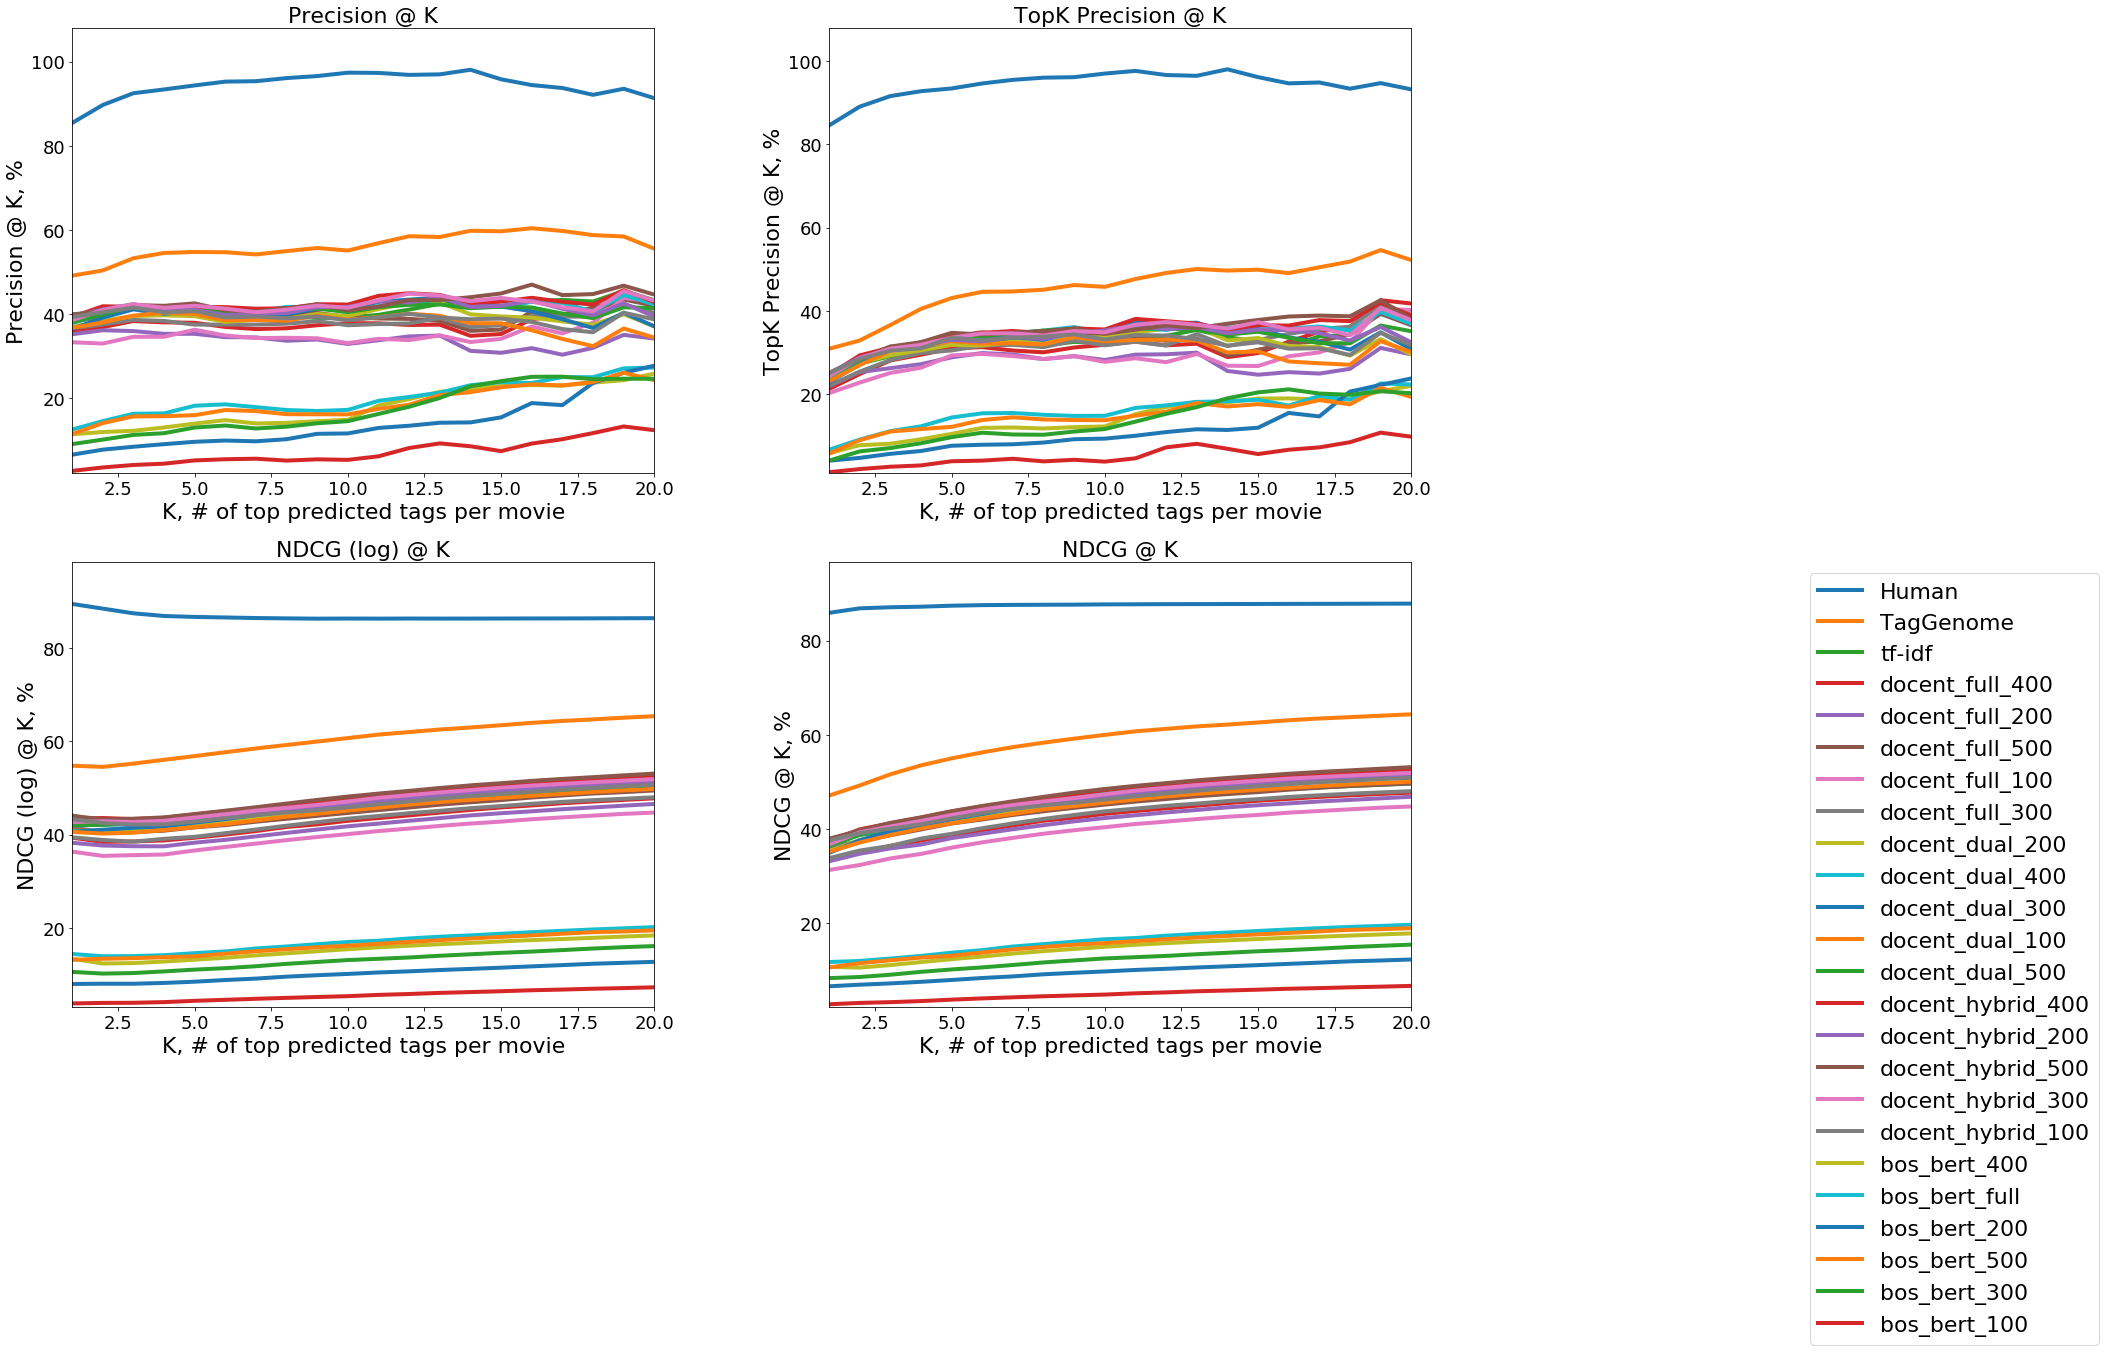

In [37]:
plot_ranking_results(results_movie_heldout_with_human)

In [39]:
print('Model\tMAP\tAUC')
print(
    '\n'.join(['%s\t%.1f\t%.2f' % (model, 100.0 * results['mean_average_precision'], results['auc'])
               for model, results in sorted(results_movie_heldout_with_human.items())]
)

SyntaxError: unexpected EOF while parsing (<ipython-input-39-d59e1bcf94bb>, line 5)

In [88]:
metric = 'precision@k' 
# metric = 'ndcg_log@k'

# name = 'Human'
# name = 'tf-idf'
# name = 'BERty-small'
# name = 'MostPopularTags'
# name = 'TagGenome'
# name = 'BERty-dual'
# name = 'BERty-dual-v2'
# print('\t\\addplot[style={blue,fill=none,mark=none}] coordinates {')
for k, x in enumerate(results_movie_heldout_with_human[name][metric]):
    print('\t\t(%d, %.2f)' % (k + 1, 100 * x))
# print('\t};\n\t\\addlegendentry{%s}' % name)

NameError: name 'name' is not defined

In [21]:
def get_num_train(path):
    for nt in [100, 200, 300, 400, 500]:
        if path.endswith('train%d_n30_th_fee' % nt):
            return nt
    return None

print(
    '\n'.join([
        '%s\t%.3f\t%.2f' % (model, results['auc'], 100.0 * results['mean_average_precision'])
        for model, results in results_movie_heldout_with_human.items()
        if get_num_train(model) == 500 and results['auc'] > 0.974
]))

can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train500_n30_th_fee	0.975	38.33


In [89]:
print(
    '\n'.join(['%s\t%.3f\t%.2f' % (model, results['auc'], 100.0 * results['mean_average_precision']) for model, results in results_movie_heldout_with_human.items()])
)

Human	0.989	84.61
TagGenome	0.984	51.52
tf-idf	0.839	35.25
predictions.th300.csv	0.744	10.69
predictions.th100.csv	0.633	5.04
predictions.th_full.csv	0.786	13.21
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-300-test.csv	0.958	39.22
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-400-test.csv	0.960	39.92
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-100-test.csv	0.948	37.92
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-200-test.csv	0.955	38.96
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-500-test.csv	0.959	40.27
egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-300-test.csv	0.959	40.31
egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-100-test.csv	0.952	39.25
egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-400-test.csv	0.962	40.66
egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-200-test.csv	0.957	40.18
egomask28-ovotfetb-bs-256-5e-6-ckpt-1200-tags-500-test.csv	0.962	40.79


In [110]:
metric = 'precision@k'

for K in [1, 5, 10]:
    print('K = %d\n------------------------------' % K)
    values = [
        (model, results[metric][K - 1])
        for model, results in results_movie_heldout_with_human.items()
    ]
    values.sort()
    for model, value in values:
        print('%s\t%.3f' % (model, value))

K = 1
------------------------------
Human	0.852
TagGenome	0.488
can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train100_n30_th_fee	0.327
can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train200_n30_th_fee	0.348
can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train300_n30_th_fee	0.359
can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train400_n30_th_fee	0.359
can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train500_n30_th_fee	0.378
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-100-test.csv	0.357
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-200-test.csv	0.365
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-300-test.csv	0.355
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-400-test.csv	0.367
ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-500-test.csv	0.374
egomask28-ovotfetb-bs-256-5e-6-ckpt-1200-tags-500-test.csv	0.392
egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-100-test.csv	0.386
egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-200-test.csv	0

In [74]:
# model_of_choise = 'can_asin_partial_delex_ptmp0.25_l128_ue_finetuning_1407000_dev_train%d_n30_th_fee'
model_of_choise = 'egomask28-ovotfetb-bs-256-5e-6-ckpt-1200-tags-%d-test.csv'

# model_of_choise = 'tf-idf'
# model_of_choise = 'TagGenome'
# model_of_choise = 'Human'
for nt in [100, 200, 300, 400, 500]:    
#     print('(%d, %f)' % (nt, results_movie_heldout_with_human[model_of_choise]['auc']))
#     print('(%d, %f)' % (nt, 100 * results_movie_heldout_with_human[model_of_choise]['mean_average_precision']))    

    print('(%d, %f)' % (nt, results_movie_heldout_with_human[model_of_choise % nt]['auc']))
#     print('(%d, %f)' % (nt, 100 * results_movie_heldout_with_human[model_of_choise % nt]['mean_average_precision']))

KeyError: 'egomask28-ovotfetb-bs-256-5e-6-ckpt-1200-tags-100-test.csv'

In [81]:
# models = ['ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-100-test.csv',
# 'ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-200-test.csv',
# 'ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-300-test.csv',
# 'ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-400-test.csv',
# 'ego5-ovotfetb-bs-256-5e-6-ckpt-1600-tags-500-test.csv']

models = ['egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-100-test.csv',
'egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-200-test.csv',
'egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-300-test.csv',
'egomask28-ovotfetb-bs-256-5e-6-ckpt-1600-tags-400-test.csv',
'egomask28-ovotfetb-bs-256-5e-6-ckpt-1200-tags-500-test.csv']

for i, m in enumerate(models):
    print('(%d, %f)' % (100 * (i + 1), 100 *results_movie_heldout_with_human[m]['mean_average_precision']))


(100, 39.250568)
(200, 40.184903)
(300, 40.313601)
(400, 40.655291)
(500, 40.793107)
